# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0k/60.0k [00:09<00:00, 6.44kFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

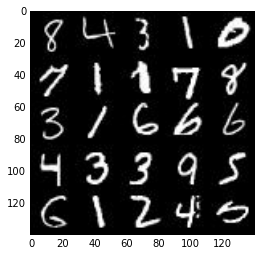

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

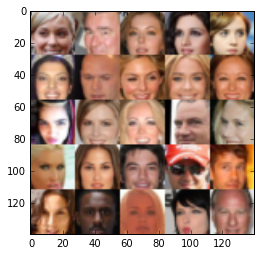

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    lr = tf.placeholder(tf.float32, (None), name = 'learning_rate')
    
    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse = reuse):
        x1 = tf.layers.conv2d(images, 64 ,5, strides = 2, padding = 'same')
        x1 = tf.nn.leaky_relu(x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.nn.leaky_relu(x2)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.nn.leaky_relu(x3)
        
        
        flatten = tf.contrib.layers.flatten(x3)
        logits = tf.layers.dense(flatten, 1)
        output = tf.nn.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7,7,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.nn.leaky_relu(x1)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides = 2, padding = 'same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.leaky_relu(x2)
        # 14x14x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides = 2, padding = 'same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.nn.leaky_relu(x3)
        # 28x28x128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides = 1, padding = 'same')
        output = tf.tanh(logits)
        #25x25xout_channel_dim
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse = False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, labels = tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_model_fake)))
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    N, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    samples, losses = [], []
    steps = 0
    print_every = 10
    show_every=100
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                batch_images *= 2
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                    
                    
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1977... Generator Loss: 3.2375
Epoch 1/2... Discriminator Loss: 0.0279... Generator Loss: 4.6563
Epoch 1/2... Discriminator Loss: 0.0938... Generator Loss: 2.8344
Epoch 1/2... Discriminator Loss: 2.4677... Generator Loss: 8.1054
Epoch 1/2... Discriminator Loss: 0.9811... Generator Loss: 3.0435
Epoch 1/2... Discriminator Loss: 1.1119... Generator Loss: 1.5153
Epoch 1/2... Discriminator Loss: 1.0486... Generator Loss: 1.4147
Epoch 1/2... Discriminator Loss: 1.1199... Generator Loss: 0.7802
Epoch 1/2... Discriminator Loss: 1.0531... Generator Loss: 1.0165
Epoch 1/2... Discriminator Loss: 0.9908... Generator Loss: 1.0042


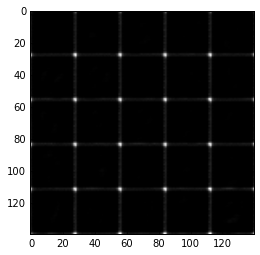

Epoch 1/2... Discriminator Loss: 1.2714... Generator Loss: 0.5954
Epoch 1/2... Discriminator Loss: 1.3025... Generator Loss: 0.4188
Epoch 1/2... Discriminator Loss: 1.3912... Generator Loss: 1.1949
Epoch 1/2... Discriminator Loss: 1.2794... Generator Loss: 0.5030
Epoch 1/2... Discriminator Loss: 1.1214... Generator Loss: 0.7381
Epoch 1/2... Discriminator Loss: 1.1259... Generator Loss: 0.7983
Epoch 1/2... Discriminator Loss: 1.6791... Generator Loss: 0.2969
Epoch 1/2... Discriminator Loss: 1.1406... Generator Loss: 1.3846
Epoch 1/2... Discriminator Loss: 1.0698... Generator Loss: 1.1671
Epoch 1/2... Discriminator Loss: 1.0116... Generator Loss: 0.9630


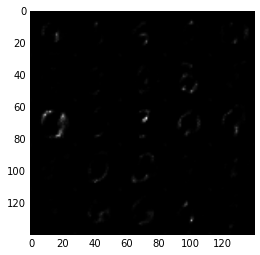

Epoch 1/2... Discriminator Loss: 1.1651... Generator Loss: 0.5273
Epoch 1/2... Discriminator Loss: 0.9915... Generator Loss: 0.7585
Epoch 1/2... Discriminator Loss: 0.9618... Generator Loss: 1.3331
Epoch 1/2... Discriminator Loss: 0.8614... Generator Loss: 1.0464
Epoch 1/2... Discriminator Loss: 1.0336... Generator Loss: 0.6063
Epoch 1/2... Discriminator Loss: 0.9782... Generator Loss: 1.5325
Epoch 1/2... Discriminator Loss: 0.8347... Generator Loss: 1.0570
Epoch 1/2... Discriminator Loss: 1.1025... Generator Loss: 0.6256
Epoch 1/2... Discriminator Loss: 0.9616... Generator Loss: 1.6868
Epoch 1/2... Discriminator Loss: 1.1355... Generator Loss: 1.6096


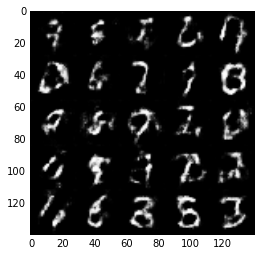

Epoch 1/2... Discriminator Loss: 1.0312... Generator Loss: 1.1220
Epoch 1/2... Discriminator Loss: 1.1014... Generator Loss: 1.4236
Epoch 1/2... Discriminator Loss: 1.0059... Generator Loss: 0.9194
Epoch 1/2... Discriminator Loss: 1.0786... Generator Loss: 0.9533
Epoch 1/2... Discriminator Loss: 0.9962... Generator Loss: 1.0488
Epoch 1/2... Discriminator Loss: 1.0126... Generator Loss: 1.0377
Epoch 1/2... Discriminator Loss: 1.0964... Generator Loss: 0.7050
Epoch 1/2... Discriminator Loss: 1.1518... Generator Loss: 0.5810
Epoch 1/2... Discriminator Loss: 1.1705... Generator Loss: 0.5822
Epoch 1/2... Discriminator Loss: 1.0740... Generator Loss: 1.3497


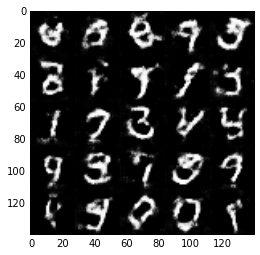

Epoch 1/2... Discriminator Loss: 1.2738... Generator Loss: 0.4795
Epoch 1/2... Discriminator Loss: 1.1001... Generator Loss: 0.7557
Epoch 1/2... Discriminator Loss: 1.2478... Generator Loss: 0.4894
Epoch 1/2... Discriminator Loss: 1.2780... Generator Loss: 0.4866
Epoch 1/2... Discriminator Loss: 1.0362... Generator Loss: 1.1894
Epoch 1/2... Discriminator Loss: 1.0804... Generator Loss: 0.9621
Epoch 2/2... Discriminator Loss: 1.0801... Generator Loss: 0.8558
Epoch 2/2... Discriminator Loss: 1.0603... Generator Loss: 0.8077
Epoch 2/2... Discriminator Loss: 1.0362... Generator Loss: 1.1529
Epoch 2/2... Discriminator Loss: 1.1663... Generator Loss: 1.7902


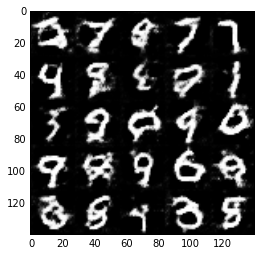

Epoch 2/2... Discriminator Loss: 1.0988... Generator Loss: 0.6864
Epoch 2/2... Discriminator Loss: 1.0513... Generator Loss: 0.9163
Epoch 2/2... Discriminator Loss: 1.3660... Generator Loss: 1.9990
Epoch 2/2... Discriminator Loss: 1.0243... Generator Loss: 1.0574
Epoch 2/2... Discriminator Loss: 1.3907... Generator Loss: 0.4287
Epoch 2/2... Discriminator Loss: 0.9459... Generator Loss: 1.1278
Epoch 2/2... Discriminator Loss: 0.9858... Generator Loss: 0.8402
Epoch 2/2... Discriminator Loss: 0.9766... Generator Loss: 1.0687
Epoch 2/2... Discriminator Loss: 1.1708... Generator Loss: 1.4586
Epoch 2/2... Discriminator Loss: 1.1391... Generator Loss: 1.2679


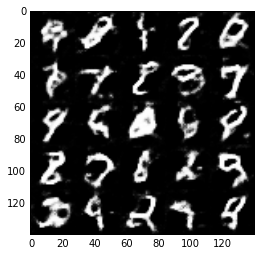

Epoch 2/2... Discriminator Loss: 0.9835... Generator Loss: 0.9502
Epoch 2/2... Discriminator Loss: 1.1842... Generator Loss: 1.3624
Epoch 2/2... Discriminator Loss: 1.2110... Generator Loss: 0.5407
Epoch 2/2... Discriminator Loss: 1.1496... Generator Loss: 1.8055
Epoch 2/2... Discriminator Loss: 0.9958... Generator Loss: 1.0191
Epoch 2/2... Discriminator Loss: 0.9374... Generator Loss: 1.0789
Epoch 2/2... Discriminator Loss: 0.9705... Generator Loss: 1.7768
Epoch 2/2... Discriminator Loss: 0.9846... Generator Loss: 0.7900
Epoch 2/2... Discriminator Loss: 0.9411... Generator Loss: 1.6111
Epoch 2/2... Discriminator Loss: 0.9119... Generator Loss: 1.1534


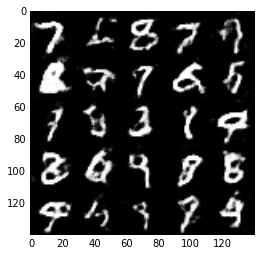

Epoch 2/2... Discriminator Loss: 0.9543... Generator Loss: 0.9628
Epoch 2/2... Discriminator Loss: 1.0723... Generator Loss: 0.5751
Epoch 2/2... Discriminator Loss: 0.8900... Generator Loss: 1.2639
Epoch 2/2... Discriminator Loss: 1.1804... Generator Loss: 0.5195
Epoch 2/2... Discriminator Loss: 0.8916... Generator Loss: 0.9566
Epoch 2/2... Discriminator Loss: 1.0175... Generator Loss: 1.2205
Epoch 2/2... Discriminator Loss: 0.8451... Generator Loss: 0.9843
Epoch 2/2... Discriminator Loss: 1.1201... Generator Loss: 1.9005
Epoch 2/2... Discriminator Loss: 0.9437... Generator Loss: 1.1346
Epoch 2/2... Discriminator Loss: 0.8210... Generator Loss: 1.0032


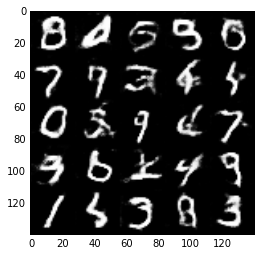

Epoch 2/2... Discriminator Loss: 0.9598... Generator Loss: 0.6779
Epoch 2/2... Discriminator Loss: 0.8749... Generator Loss: 1.0465
Epoch 2/2... Discriminator Loss: 1.2257... Generator Loss: 2.3050
Epoch 2/2... Discriminator Loss: 1.0811... Generator Loss: 0.6228
Epoch 2/2... Discriminator Loss: 0.9655... Generator Loss: 0.6863
Epoch 2/2... Discriminator Loss: 0.8618... Generator Loss: 0.9865
Epoch 2/2... Discriminator Loss: 1.3603... Generator Loss: 1.0224
Epoch 2/2... Discriminator Loss: 0.7720... Generator Loss: 1.1725
Epoch 2/2... Discriminator Loss: 0.9190... Generator Loss: 1.2363
Epoch 2/2... Discriminator Loss: 0.8645... Generator Loss: 1.1836


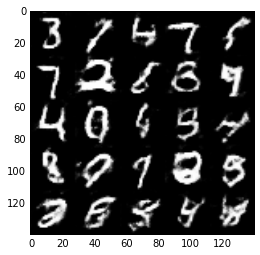

Epoch 2/2... Discriminator Loss: 0.9284... Generator Loss: 0.8806
Epoch 2/2... Discriminator Loss: 1.0021... Generator Loss: 0.6834
Epoch 2/2... Discriminator Loss: 0.9168... Generator Loss: 1.6036


In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5199... Generator Loss: 1.8421
Epoch 1/1... Discriminator Loss: 0.5442... Generator Loss: 1.4343
Epoch 1/1... Discriminator Loss: 0.8369... Generator Loss: 5.9378
Epoch 1/1... Discriminator Loss: 1.4909... Generator Loss: 0.3807
Epoch 1/1... Discriminator Loss: 0.8401... Generator Loss: 1.5458
Epoch 1/1... Discriminator Loss: 0.7688... Generator Loss: 1.9277
Epoch 1/1... Discriminator Loss: 0.5622... Generator Loss: 1.5410
Epoch 1/1... Discriminator Loss: 0.5012... Generator Loss: 1.5540
Epoch 1/1... Discriminator Loss: 0.6014... Generator Loss: 2.0984
Epoch 1/1... Discriminator Loss: 0.6232... Generator Loss: 1.1055


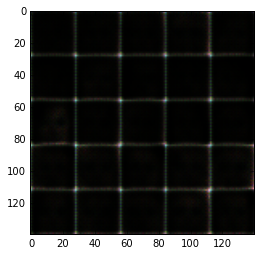

Epoch 1/1... Discriminator Loss: 0.6742... Generator Loss: 1.2867
Epoch 1/1... Discriminator Loss: 0.3270... Generator Loss: 2.4985
Epoch 1/1... Discriminator Loss: 0.8731... Generator Loss: 6.9145
Epoch 1/1... Discriminator Loss: 1.7458... Generator Loss: 7.6610
Epoch 1/1... Discriminator Loss: 2.1358... Generator Loss: 6.5699
Epoch 1/1... Discriminator Loss: 0.2796... Generator Loss: 3.0157
Epoch 1/1... Discriminator Loss: 0.9324... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 0.5906... Generator Loss: 1.9393
Epoch 1/1... Discriminator Loss: 0.2089... Generator Loss: 5.5705
Epoch 1/1... Discriminator Loss: 0.3898... Generator Loss: 1.4219


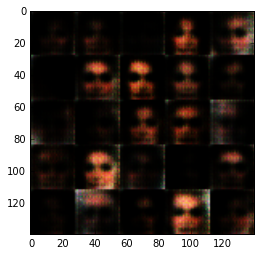

Epoch 1/1... Discriminator Loss: 0.8129... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 0.7696... Generator Loss: 1.1561
Epoch 1/1... Discriminator Loss: 0.8514... Generator Loss: 1.4360
Epoch 1/1... Discriminator Loss: 0.9296... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.0780... Generator Loss: 4.9241
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.4403
Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 1.6253
Epoch 1/1... Discriminator Loss: 0.9370... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 0.8728... Generator Loss: 1.1545


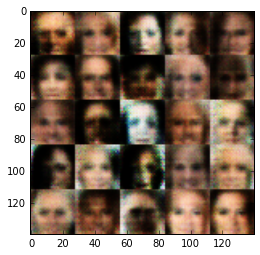

Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 1.2466
Epoch 1/1... Discriminator Loss: 0.8892... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 0.7360... Generator Loss: 1.4480
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.4689
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.4272
Epoch 1/1... Discriminator Loss: 0.9007... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.7070... Generator Loss: 4.0152
Epoch 1/1... Discriminator Loss: 0.6694... Generator Loss: 1.1095
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 1.9550


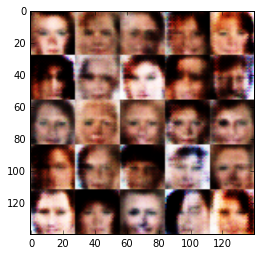

Epoch 1/1... Discriminator Loss: 2.3304... Generator Loss: 0.1400
Epoch 1/1... Discriminator Loss: 0.6895... Generator Loss: 1.3984
Epoch 1/1... Discriminator Loss: 0.6079... Generator Loss: 1.2002
Epoch 1/1... Discriminator Loss: 0.9882... Generator Loss: 1.4068
Epoch 1/1... Discriminator Loss: 0.5012... Generator Loss: 4.1499
Epoch 1/1... Discriminator Loss: 1.8590... Generator Loss: 1.2652
Epoch 1/1... Discriminator Loss: 0.9463... Generator Loss: 1.3085
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 0.5164
Epoch 1/1... Discriminator Loss: 0.3535... Generator Loss: 1.5800
Epoch 1/1... Discriminator Loss: 0.8406... Generator Loss: 1.2053


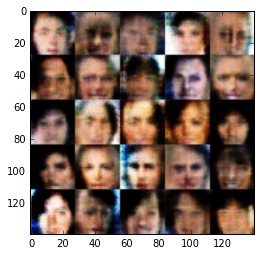

Epoch 1/1... Discriminator Loss: 1.5817... Generator Loss: 1.2592
Epoch 1/1... Discriminator Loss: 1.9261... Generator Loss: 0.2054
Epoch 1/1... Discriminator Loss: 0.6657... Generator Loss: 1.1258
Epoch 1/1... Discriminator Loss: 0.8909... Generator Loss: 0.9723
Epoch 1/1... Discriminator Loss: 2.1128... Generator Loss: 0.1789
Epoch 1/1... Discriminator Loss: 2.3360... Generator Loss: 1.3654
Epoch 1/1... Discriminator Loss: 0.3264... Generator Loss: 2.0115
Epoch 1/1... Discriminator Loss: 0.4710... Generator Loss: 1.5196
Epoch 1/1... Discriminator Loss: 0.5757... Generator Loss: 3.2283
Epoch 1/1... Discriminator Loss: 2.1334... Generator Loss: 0.1667


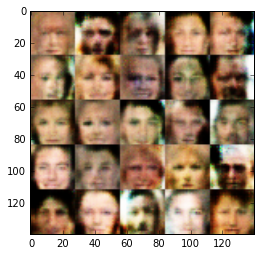

Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.5504
Epoch 1/1... Discriminator Loss: 0.6039... Generator Loss: 1.0711
Epoch 1/1... Discriminator Loss: 0.3203... Generator Loss: 3.6071
Epoch 1/1... Discriminator Loss: 0.8000... Generator Loss: 2.1952
Epoch 1/1... Discriminator Loss: 0.3864... Generator Loss: 2.0577
Epoch 1/1... Discriminator Loss: 0.4875... Generator Loss: 1.8160
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 3.6463
Epoch 1/1... Discriminator Loss: 0.7200... Generator Loss: 1.1252
Epoch 1/1... Discriminator Loss: 0.5602... Generator Loss: 1.3406
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 0.5893


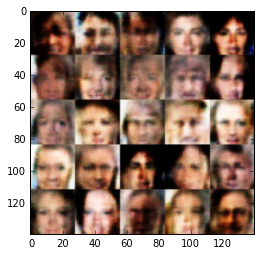

Epoch 1/1... Discriminator Loss: 0.4837... Generator Loss: 1.5433
Epoch 1/1... Discriminator Loss: 0.6897... Generator Loss: 0.9790
Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 1.4643
Epoch 1/1... Discriminator Loss: 0.5120... Generator Loss: 1.5792
Epoch 1/1... Discriminator Loss: 0.5679... Generator Loss: 2.6789
Epoch 1/1... Discriminator Loss: 0.4736... Generator Loss: 1.3421
Epoch 1/1... Discriminator Loss: 1.9050... Generator Loss: 0.5202
Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 1.1625
Epoch 1/1... Discriminator Loss: 0.4424... Generator Loss: 2.6159
Epoch 1/1... Discriminator Loss: 1.5934... Generator Loss: 1.1641


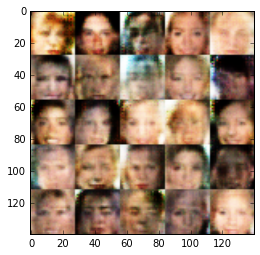

Epoch 1/1... Discriminator Loss: 0.4266... Generator Loss: 1.5192
Epoch 1/1... Discriminator Loss: 0.5830... Generator Loss: 0.9469
Epoch 1/1... Discriminator Loss: 0.6255... Generator Loss: 1.7465
Epoch 1/1... Discriminator Loss: 0.3820... Generator Loss: 2.3731
Epoch 1/1... Discriminator Loss: 0.9287... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 0.9229... Generator Loss: 1.0478
Epoch 1/1... Discriminator Loss: 0.3893... Generator Loss: 1.7070
Epoch 1/1... Discriminator Loss: 0.6190... Generator Loss: 1.1921
Epoch 1/1... Discriminator Loss: 0.2976... Generator Loss: 3.8191


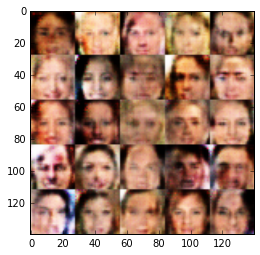

Epoch 1/1... Discriminator Loss: 2.5724... Generator Loss: 0.2703
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 0.5456... Generator Loss: 1.6298
Epoch 1/1... Discriminator Loss: 1.0180... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 0.9600... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 0.1852... Generator Loss: 3.1562
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 1.6512
Epoch 1/1... Discriminator Loss: 1.5335... Generator Loss: 0.4790
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 0.9998


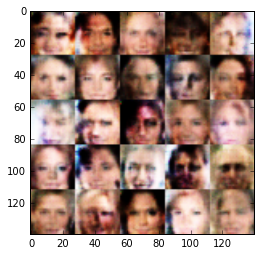

Epoch 1/1... Discriminator Loss: 0.4639... Generator Loss: 1.7454
Epoch 1/1... Discriminator Loss: 1.2079... Generator Loss: 3.1194
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 1.4679
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 0.5595... Generator Loss: 2.9057
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 0.7295... Generator Loss: 2.9148
Epoch 1/1... Discriminator Loss: 0.4014... Generator Loss: 3.0967
Epoch 1/1... Discriminator Loss: 0.4972... Generator Loss: 1.4472
Epoch 1/1... Discriminator Loss: 0.7819... Generator Loss: 0.9257


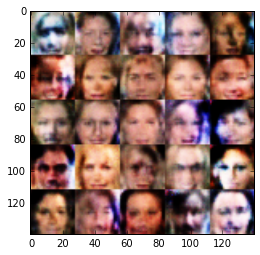

Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 4.0153
Epoch 1/1... Discriminator Loss: 0.6104... Generator Loss: 2.6054
Epoch 1/1... Discriminator Loss: 0.9495... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 0.2848... Generator Loss: 4.6950
Epoch 1/1... Discriminator Loss: 2.5334... Generator Loss: 0.1089
Epoch 1/1... Discriminator Loss: 0.7757... Generator Loss: 2.4271
Epoch 1/1... Discriminator Loss: 2.0172... Generator Loss: 0.1983
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 4.6963
Epoch 1/1... Discriminator Loss: 1.7560... Generator Loss: 0.2707
Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 1.0755


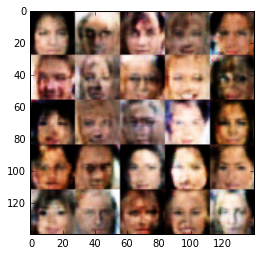

Epoch 1/1... Discriminator Loss: 0.1904... Generator Loss: 3.1542
Epoch 1/1... Discriminator Loss: 1.0080... Generator Loss: 2.6724
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 1.0080
Epoch 1/1... Discriminator Loss: 1.5211... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.7518


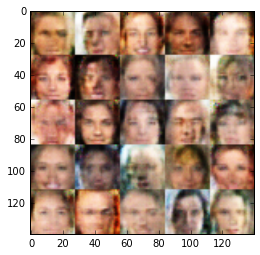

Epoch 1/1... Discriminator Loss: 1.5648... Generator Loss: 0.4898
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 0.8530
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 1.3306


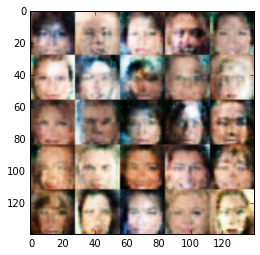

Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 0.9234
Epoch 1/1... Discriminator Loss: 1.0885... Generator Loss: 0.9698
Epoch 1/1... Discriminator Loss: 0.3876... Generator Loss: 2.4478
Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 0.9202... Generator Loss: 1.1402
Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 0.9861... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 0.5168


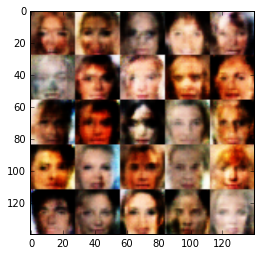

Epoch 1/1... Discriminator Loss: 0.8266... Generator Loss: 1.8186
Epoch 1/1... Discriminator Loss: 0.7170... Generator Loss: 1.8142
Epoch 1/1... Discriminator Loss: 0.3441... Generator Loss: 2.0438
Epoch 1/1... Discriminator Loss: 0.4661... Generator Loss: 2.0250
Epoch 1/1... Discriminator Loss: 0.5257... Generator Loss: 1.8008
Epoch 1/1... Discriminator Loss: 0.2230... Generator Loss: 2.0635
Epoch 1/1... Discriminator Loss: 0.4133... Generator Loss: 1.3661
Epoch 1/1... Discriminator Loss: 1.7117... Generator Loss: 2.3912


In [16]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.